# Team 15
113062507 沈家同   

113062657 黃盛揚

113062502 謝喆安   

113062619 郭彥廷

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.applications import DenseNet201
from keras.applications import EfficientNetB3
from keras import layers, models
from datetime import datetime
from tqdm import tqdm
import os
import shutil
import random
from collections import defaultdict, Counter
import cv2
import numpy as np
import matplotlib.pyplot as plt

2024-11-23 21:15:52.774582: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 21:15:52.840134: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 21:15:52.855008: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 21:15:53.133063: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-11-23 21:15:53.598792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-23 21:15:53.615171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-23 21:15:53.617064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-23 21:15:53.619400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [3]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Balance

在統計所有資料的class後會發現，person的數量明顯高於其他的class，這會導致後面預測的時候經常預測成person，因此我們決定平衡每個class的數量。在平衡的時候，會從第一張圖看到最後一張，當檢查到這張圖中的每個class的數量小於target count(設定為7000)時，則複製這一張圖並更新class的數量，重複執行直到每個class的數量都達到target count。

In [5]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [6]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './data/pascal_voc_training_data.txt'
IMAGE_DIR = './data/VOCdevkit_train/VOC2007/JPEGImages/'

#new dataset
NEW_DATA_PATH = './data/new_training_data.txt'
NEW_IMAGE_DIR = './data/new_JPEG/'
AUG_DATA_PATH = './data/aug_training_data.txt'
AUG_IMAGE_DIR = './data/aug_JPEG/'
target_count = 7000

In [7]:

def read_annotations(file_path):
    annotations = defaultdict(list)
    with open(file_path, 'r') as f:
        for line_number, line in enumerate(f, start=1):
            parts = line.strip().split()
            
            # 檢查是否有至少一個 bounding box（6 個元素）
            if len(parts) < 6 or (len(parts) - 1) % 5 != 0:
                print(f"Warning: Line {line_number} in {file_path} does not match the expected format. Skipping this line.")
                continue
            
            img_name = parts[0]
            try:
                # 每 5 個數據組成一個 bounding box (x_min, y_min, x_max, y_max, class_id)
                for i in range(1, len(parts), 5):
                    x_min, y_min, x_max, y_max, class_id = map(int, parts[i:i+5])
                    annotations[img_name].append((x_min, y_min, x_max, y_max, class_id))
            except ValueError as e:
                print(f"Error: Line {line_number} in {file_path} contains non-integer values. {e}")
                
    return annotations

def count_classes(annotations):
    class_counter = Counter([bbox[4] for boxes in annotations.values() for bbox in boxes])
    return class_counter

def copy_and_balance_data(annotations, source_folder, target_folder, target_txt_path, target_count):
    os.makedirs(target_folder, exist_ok=True)
    class_counts = count_classes(annotations)
    
    with open(target_txt_path, "w") as target_file:
        for img_name, bboxes in annotations.items():
            source_img_path = os.path.join(source_folder, img_name)
            target_img_name = img_name
            target_img_path = os.path.join(target_folder, target_img_name)
            
            if os.path.exists(source_img_path):
                shutil.copy2(source_img_path, target_img_path)
            
            line = [target_img_name]
            for bbox in bboxes:
                x_min, y_min, x_max, y_max, class_id = bbox
                line.extend([str(x_min), str(y_min), str(x_max), str(y_max), str(class_id)])
            
            target_file.write(" ".join(line) + "\n")
        
        while any(count < target_count for count in class_counts.values()):
            for img_name, bboxes in annotations.items():
                if all(class_counts[bbox[4]] < target_count for bbox in bboxes):
                    source_img_path = os.path.join(source_folder, img_name)
                    target_img_name = f"{img_name.split('.')[0]}_aug_{random.randint(1000,9999)}.jpg"  
                    target_img_path = os.path.join(target_folder, target_img_name)
                    
                    if os.path.exists(source_img_path):
                        shutil.copy2(source_img_path, target_img_path)
                    
                    line = [target_img_name]
                    for bbox in bboxes:
                        x_min, y_min, x_max, y_max, class_id = bbox
                        line.extend([str(x_min), str(y_min), str(x_max), str(y_max), str(class_id)])
                        class_counts[class_id] += 1
                    
                    target_file.write(" ".join(line) + "\n")
                    
                    if all(count >= target_count for count in class_counts.values()):
                        print("All classes have reached the target count.")
                        return


In [8]:
annotations = read_annotations(DATA_PATH)
class_counts = count_classes(annotations)
print(class_counts)
copy_and_balance_data(annotations, IMAGE_DIR, NEW_IMAGE_DIR, NEW_DATA_PATH, target_count)
annotations = read_annotations(NEW_DATA_PATH)
class_counts = count_classes(annotations)
print(class_counts)

Counter({14: 5392, 6: 1636, 8: 1425, 4: 629, 15: 620, 2: 599, 11: 536, 17: 419, 1: 417, 12: 403, 3: 398, 13: 390, 7: 389, 19: 366, 9: 356, 16: 353, 0: 331, 18: 328, 10: 309, 5: 272})
All classes have reached the target count.
Counter({2: 7003, 14: 7002, 9: 7002, 6: 7001, 1: 7001, 0: 7001, 4: 7001, 13: 7001, 8: 7000, 12: 7000, 7: 7000, 11: 7000, 18: 7000, 10: 7000, 19: 7000, 15: 7000, 3: 7000, 17: 7000, 16: 7000, 5: 7000})


## Data Augmentation


### Transform :

我們有實作多種Transform的技巧如下所列，分成兩種，為改變圖形大小或形狀的，跟改變圖片色溫或加躁點等等的，跟改變圖片像素的

*    flip_horizontal
*    rotate
*    scale
*    translate
*    shear
*    brightness_contrast
*    blur
*    noise
*    color_temperature
*    cutout
接著會將這兩類的方式各別挑一種加到同一張圖片上，若不為新複製的圖片則不做augmentation。在rotate , scale ,shear 跟 translate 中會造成圖片有部分缺失，原本是填充黑色，但發現可能會影響到tvmonitor的判斷，所以改成用白色。

### Mosaic :

在本次Cup當中，有使用Mosaic的技術。Msaic是YOLOv4所提出的數據增強方法，其概念類似CutMix，也是將不同圖片做裁減過後拼接在一起的方法，但與CutMix不同的點在於，CutMix拼接後的圖片會遮蔽原圖片，在一定程度上可能會造成辨識變的困難。我們也有將Mosaic的data做balance，但一開始有發現若Mosaic的數量太多可能會導致model學壞，所以有控制Mosaic所產生的數量，並且若為了完全平衡可能導致重複生成很多個一樣的圖片。所以最後在把augmentation的數量提高到6000的情況下可以讓balacing維持在90%左右

In [9]:
def flip_horizontal(image, bboxes):

    flipped_image = cv2.flip(image, 1)
    h, w = image.shape[:2]
    flipped_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        flipped_bbox = [w - x_max, y_min, w - x_min, y_max]
        flipped_bboxes.append(flipped_bbox)
    return flipped_image, flipped_bboxes

def rotate_image_and_bboxes(image, bboxes, angle):
    h, w = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    rotated_image = cv2.warpAffine(image, M, (w, h), borderValue=(255, 255, 255))

    rotated_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        corners = np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max]
        ])
        ones = np.ones((corners.shape[0], 1))
        corners_ones = np.hstack([corners, ones])
        transformed_corners = M.dot(corners_ones.T).T
        x_coords = transformed_corners[:, 0]
        y_coords = transformed_corners[:, 1]
        x_min_new = x_coords.min()
        y_min_new = y_coords.min()
        x_max_new = x_coords.max()
        y_max_new = y_coords.max()
        rotated_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])

    return rotated_image, rotated_bboxes

def scale_image_and_bboxes(image, bboxes, scale_factor_x, scale_factor_y):

    h, w = image.shape[:2]
    new_w = int(w * scale_factor_x)
    new_h = int(h * scale_factor_y)
    scaled_image = cv2.resize(image, (new_w, new_h))
    scaled_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_min_new = x_min * scale_factor_x
        y_min_new = y_min * scale_factor_y
        x_max_new = min(x_max * scale_factor_x , w)
        y_max_new = min(y_max * scale_factor_y , h)
        scaled_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])

    canvas = np.ones(image.shape, dtype=np.uint8) * 255

    y_lim = int(min(scale_factor_y, 1) * image.shape[0])
    x_lim = int(min(scale_factor_x, 1) * image.shape[1])

    canvas[:y_lim, :x_lim, :] = scaled_image[:y_lim, :x_lim, :]

    scaled_image = canvas
    return scaled_image, scaled_bboxes

def translate_image_and_bboxes(image, bboxes):
  
    h, w = image.shape[:2]

    min_xmin = min([bbox[0] for bbox in bboxes])
    max_xmax = max([bbox[2] for bbox in bboxes])
    max_left_trans = min_xmin
    max_right_trans = w - max_xmax

    min_ymin = min([bbox[1] for bbox in bboxes])
    max_ymax = max([bbox[3] for bbox in bboxes])
    max_up_trans = min_ymin
    max_down_trans = h - max_ymax

    if max_left_trans == 0 and max_right_trans == 0 and max_up_trans == 0 and max_down_trans == 0:
        return image, bboxes
    

    tx = random.uniform(max(-max_left_trans , -image.shape[1] * 0.2), image.shape[1] * 0.2)
    ty = random.uniform(max(-max_up_trans , -image.shape[0] * 0.2), image.shape[0] * 0.2)

    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_image = cv2.warpAffine(image, M, (w, h) , borderValue=(255, 255, 255)) 
    translated_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_min_new = x_min + tx
        y_min_new = y_min + ty
        x_max_new = x_max + tx
        y_max_new = y_max + ty
        translated_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])
    return translated_image, translated_bboxes

def shear_image_and_bboxes(image, bboxes):
    shear_factor_x = random.uniform(-0.15 , 0.15)
    shear_factor_y = random.uniform(-0.15 , 0.15)

    h, w = image.shape[:2]
    M = np.array([[1, shear_factor_x, 0], [shear_factor_y, 1, 0]], dtype=np.float32)
    nW = int(w + abs(shear_factor_y) * h)
    nH = int(h + abs(shear_factor_x) * w)
    sheared_image = cv2.warpAffine(image, M, (nW, nH), borderValue=(255, 255, 255))
    sheared_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        corners = np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max]
        ])
        transformed_corners = np.dot(corners, M[:2, :2].T) + M[:2, 2]

        x_coords = transformed_corners[:, 0]
        y_coords = transformed_corners[:, 1]
        x_min_new = x_coords.min()
        y_min_new = y_coords.min()
        x_max_new = x_coords.max()
        y_max_new = y_coords.max()

        sheared_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])
    return sheared_image, sheared_bboxes

def adjust_brightness_contrast(image):
    
    alpha = random.uniform(0.8, 1.2)  
    beta = random.uniform(-30, 30)    
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

def apply_blur(image):
    blur_types = ['average', 'gaussian', 'median', 'bilateral']
    blur_type = random.choice(blur_types)

    if blur_type == 'average':
        ksize = random.choice([3, 5])
        blurred_image = cv2.blur(image, (ksize, ksize))
    elif blur_type == 'gaussian':
        ksize = random.choice([3, 5])
        blurred_image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    elif blur_type == 'median':
        ksize = random.choice([3, 5])
        blurred_image = cv2.medianBlur(image, ksize)
    elif blur_type == 'bilateral':
        d = random.randint(3, 5)
        sigmaColor = random.randint(50, 100)
        sigmaSpace = random.randint(50, 100)
        blurred_image = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    else:
        blurred_image = image.copy()

    return blurred_image

def apply_noise(image):
    std_dev = random.uniform(0.5, 1.5) 
    noise = np.random.normal(0, std_dev, image.shape).astype(np.uint8)
    noisy_image = image.astype(np.int16) + noise * 0.4
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

def apply_color_temperature(image , positive_range=(15, 25), negative_range=(-25, -15)):

    if random.choice([True, False]):
        temperature_shift = random.randint(*positive_range) 
    else:
        temperature_shift = random.randint(*negative_range)  
    image = image.astype(np.float32)
    if temperature_shift > 0:  
        image[:, :, 0] -= temperature_shift 
        image[:, :, 2] += temperature_shift 
    else:  
        image[:, :, 0] += abs(temperature_shift)  
        image[:, :, 2] -= abs(temperature_shift)  

    image = np.clip(image, 0, 255).astype(np.uint8)

    return image

def cutout(image):
    h, w = image.shape[:2]
    num_cutouts = random.randint(5 , 10)
    for _ in range(num_cutouts):
        mask_size = 20
        
        cx = np.random.randint(w)
        cy = np.random.randint(h)
        
        x1 = np.clip(cx - mask_size // 2, 0, w)
        y1 = np.clip(cy - mask_size // 2, 0, h)
        x2 = np.clip(cx + mask_size // 2, 0, w)
        y2 = np.clip(cy + mask_size // 2, 0, h)
        
        image[y1:y2, x1:x2] = 255  
    
    return image

In [10]:
def random_augment_and_replace_images(image_folder, data_path, output_image_folder, output_data_path,
                                      augmentations_to_apply=None):
    
    if os.path.exists(output_image_folder):
        shutil.rmtree(output_image_folder)
        os.makedirs(output_image_folder)
    else:
        os.makedirs(output_image_folder)

    available_augmentations = {
        'flip_horizontal': flip_horizontal,
        'rotate': rotate_image_and_bboxes,
        'scale': scale_image_and_bboxes,
        'translate': translate_image_and_bboxes,
        'shear' :shear_image_and_bboxes,
        'brightness_contrast': adjust_brightness_contrast,
        'blur': apply_blur,
        'noise': apply_noise,
        'color_temperature':apply_color_temperature,
        'cutout' : cutout,
    }

    if augmentations_to_apply is None:
        augmentations_to_apply = list(available_augmentations.keys())

    with open(data_path, 'r') as f:
        lines = f.readlines()

    new_annotations = []
    
    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        bbox_data = parts[1:]

        bboxes = []
        category_ids = []
        for i in range(0, len(bbox_data), 5):
            x_min = float(bbox_data[i])
            y_min = float(bbox_data[i+1])
            x_max = float(bbox_data[i+2])
            y_max = float(bbox_data[i+3])
            cls = int(bbox_data[i+4])
            bboxes.append([x_min, y_min, x_max, y_max])
            category_ids.append(cls)

        image_path = os.path.join(image_folder, filename)
        output_image_path = os.path.join(output_image_folder, filename)
        image = cv2.imread(image_path)
        if image is None:
            continue

        augmented_image = image.copy()
        augmented_bboxes = bboxes.copy()

        shape_altering_augs = ['rotate', 'scale' , 'translate' , 'flip_horizontal' , 'shear' ]
        content_altering_augs = ['brightness_contrast', 'blur', 'noise' , 'color_temperature' , 'cutout']
        if '_aug_' in filename:
            chosen_augmentations = [random.choice(shape_altering_augs) , random.choice(content_altering_augs)]
        else:
            chosen_augmentations = []
            

        for aug in chosen_augmentations:
            if aug in available_augmentations:
                augmentation_func = available_augmentations[aug]
                if aug in ['rotate', 'scale']:
                    if aug == 'rotate':
                        if random.choice([True, False]):
                            angle = random.uniform(-30, -15)
                        else:
                            angle = random.uniform(15, 30)
                        augmented_image, augmented_bboxes = augmentation_func(augmented_image, augmented_bboxes, angle)
                    elif aug == 'scale':
                        scale_factor_x = random.uniform(0.8, 1.2)
                        scale_factor_y = random.uniform(0.8, 1.2)
                        augmented_image, augmented_bboxes = augmentation_func(augmented_image, augmented_bboxes, scale_factor_x, scale_factor_y)
                elif aug == 'translate' or aug == 'shear':
                    augmented_image, augmented_bboxes = augmentation_func(augmented_image, augmented_bboxes)
                elif aug == 'brightness_contrast' or aug == 'blur' or aug == 'noise' or aug == 'color_temperature' or aug == 'cutout':
                    augmented_image = augmentation_func(augmented_image)

        valid_bboxes = []
        valid_category_ids = []
        for bbox, cls in zip(augmented_bboxes, category_ids):
            x_min, y_min, x_max, y_max = bbox
            x_min = max(0, min(x_min, augmented_image.shape[1] - 1))
            y_min = max(0, min(y_min, augmented_image.shape[0] - 1))
            x_max = max(0, min(x_max, augmented_image.shape[1] - 1))
            y_max = max(0, min(y_max, augmented_image.shape[0] - 1))

            if x_max > x_min and y_max > y_min:
                valid_bboxes.append([x_min, y_min, x_max, y_max])
                valid_category_ids.append(cls)

        if len(valid_bboxes) == 0:
            continue

        cv2.imwrite(output_image_path, augmented_image)

        annotation_line = [filename]
        for bbox, cls in zip(valid_bboxes, valid_category_ids):
            x_min, y_min, x_max, y_max = bbox
            annotation_line.extend([str(int(round(x_min))), str(int(round(y_min))),
                                    str(int(round(x_max))), str(int(round(y_max))), str(cls)])
        new_annotations.append(' '.join(annotation_line))

    with open(output_data_path, 'w') as f:
        for annotation in new_annotations:
            f.write(annotation + '\n')

In [11]:
random_augment_and_replace_images(NEW_IMAGE_DIR, NEW_DATA_PATH , AUG_IMAGE_DIR , AUG_DATA_PATH)

In [12]:
def show_visualization_multiple_boxes(image_path, boxes, classes_name):
    np_img = cv2.imread(image_path)
    if np_img is None:
        print("Error: Unable to load image at path:", image_path)
        return
    
    IMAGE_SIZE = 448  
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    resized_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

    for (xmin, ymin, xmax, ymax, class_num) in boxes:
        class_name = classes_name[class_num]

        cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 2)
        
        cv2.putText(resized_img, class_name, (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    print(resized_img.shape)
    filename = os.path.basename(image_path)
    print(filename)
    plt.imshow(resized_img)
    plt.axis("off")
    plt.show()

def read_annotations(data_path):
    annotations = {}
    with open(data_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        bbox_data = parts[1:]
        boxes = []
        for i in range(0, len(bbox_data), 5):
            xmin = float(bbox_data[i])
            ymin = float(bbox_data[i + 1])
            xmax = float(bbox_data[i + 2])
            ymax = float(bbox_data[i + 3])
            class_num = int(bbox_data[i + 4])
            boxes.append((xmin, ymin, xmax, ymax, class_num))
        annotations[filename] = boxes
    return annotations

def visualize_random_images(image_folder, data_path, num_images):
    annotations = read_annotations(data_path)
    image_names = list(annotations.keys())
    random.shuffle(image_names)
    selected_images = image_names[:num_images]
    for image_name in selected_images:
        image_path = os.path.join(image_folder, image_name)
        boxes = annotations[image_name]
        print(image_name)
        show_visualization_multiple_boxes(image_path, boxes, classes_name)



003157_aug_5096.jpg
(505, 378, 3)
003157_aug_5096.jpg


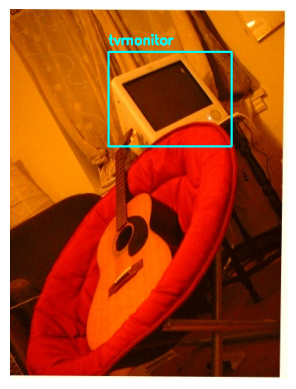

007713_aug_8959.jpg
(331, 500, 3)
007713_aug_8959.jpg


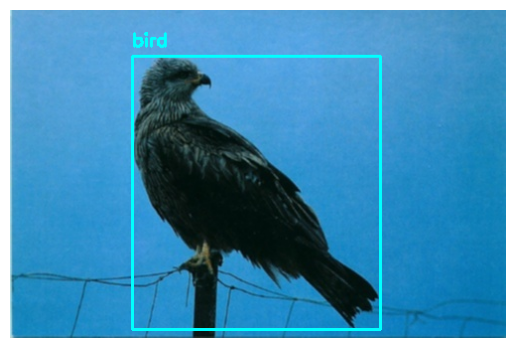

000720_aug_7177.jpg
(367, 509, 3)
000720_aug_7177.jpg


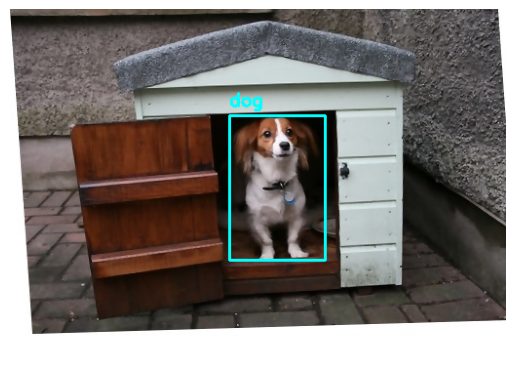

000208_aug_9852.jpg
(375, 500, 3)
000208_aug_9852.jpg


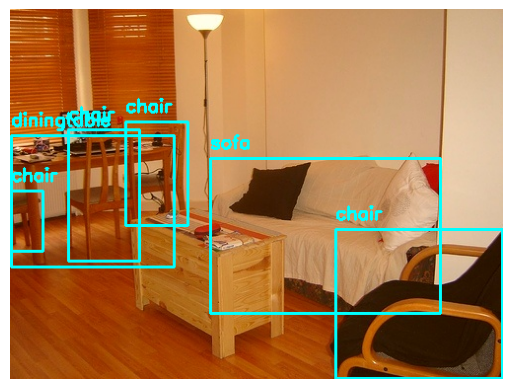

000486_aug_4055.jpg
(500, 375, 3)
000486_aug_4055.jpg


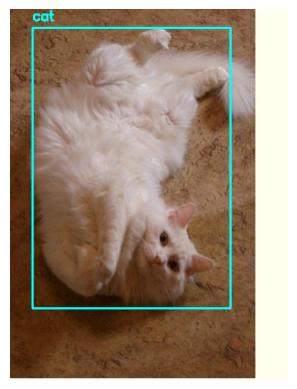

009540_aug_7527.jpg
(333, 500, 3)
009540_aug_7527.jpg


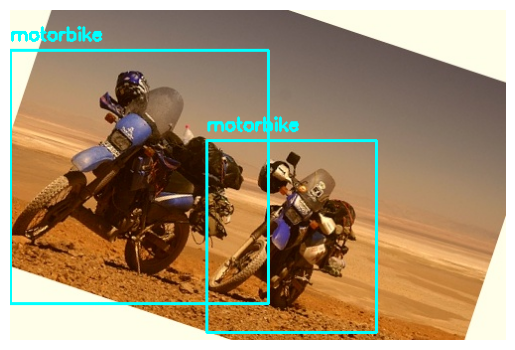

004936_aug_6908.jpg
(375, 500, 3)
004936_aug_6908.jpg


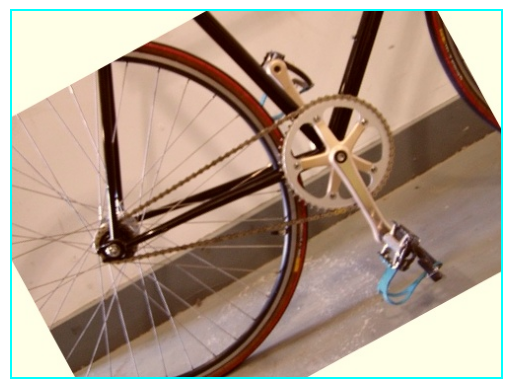

006569_aug_1606.jpg
(229, 500, 3)
006569_aug_1606.jpg


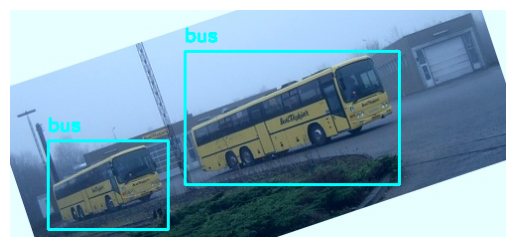

007603_aug_5305.jpg
(375, 500, 3)
007603_aug_5305.jpg


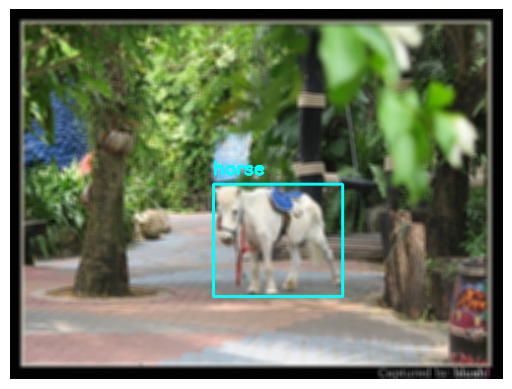

006215_aug_9214.jpg
(500, 375, 3)
006215_aug_9214.jpg


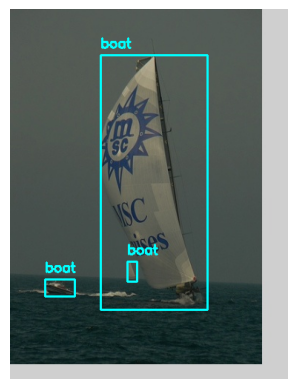

In [13]:
visualize_random_images(AUG_IMAGE_DIR, AUG_DATA_PATH, num_images = 10)

In [14]:
annotations = read_annotations(AUG_DATA_PATH)
class_counts = count_classes(annotations)
print(class_counts)

Counter({7: 6997, 14: 6991, 11: 6991, 18: 6989, 17: 6986, 2: 6980, 13: 6974, 19: 6971, 0: 6970, 12: 6965, 9: 6965, 15: 6958, 1: 6954, 4: 6941, 5: 6941, 8: 6940, 3: 6921, 16: 6913, 6: 6904, 10: 6720})


## Mosaic 

In [ ]:
# Common parameters
IMAGE_SIZE = 448
TARGET_COUNT = 3000
MOS_DATA_PATH = './data/mos_training_data.txt'
MOS_IMAGE_DIR = './data/mos_JPEG/'

In [17]:
def read_annotations(file_path):
    annotations = defaultdict(list)
    with open(file_path, 'r') as f:
        for line_number, line in enumerate(f, start=1):
            parts = line.strip().split()
            if len(parts) < 6 or (len(parts) - 1) % 5 != 0:
                print(f"Warning: Line {line_number} in {file_path} does not match the expected format. Skipping this line.")
                continue
            img_name = parts[0]
            for i in range(1, len(parts), 5):
                x_min, y_min, x_max, y_max, class_id = map(int, parts[i:i+5])
                annotations[img_name].append((x_min, y_min, x_max, y_max, class_id))
    return annotations

def count_classes(annotations):
    class_counter = Counter([bbox[4] for boxes in annotations.values() for bbox in boxes])
    return class_counter

def init_classes(annotations):
    class_counter = Counter([bbox[4] for boxes in annotations.values() for bbox in boxes])
    for cls in class_counter:
        class_counter[cls] = 0
    return class_counter

def load_image_and_labels(img_folder, img_name, bboxes):
    img = cv2.imread(os.path.join(img_folder, img_name))
    original_height, original_width = img.shape[:2]

    img = cv2.resize(img, (IMAGE_SIZE //2, IMAGE_SIZE //2 ))
    resized_height, resized_width = IMAGE_SIZE //2 , IMAGE_SIZE //2

    width_scale = resized_width / original_width
    height_scale = resized_height / original_height

    adjusted_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max, class_id = bbox
        x_min = int(x_min * width_scale)
        y_min = int(y_min * height_scale)
        x_max = int(x_max * width_scale)
        y_max = int(y_max * height_scale)
        adjusted_bboxes.append((x_min, y_min, x_max, y_max, class_id))
    
    return img, adjusted_bboxes

def mosaic_augmentation(images_and_labels , min_distance = 10 , min_area = 500):
    h, w, _ = images_and_labels[0][0].shape
    mosaic_image = np.zeros((h * 2, w * 2, 3), dtype=np.uint8)
    mosaic_labels = []
    positions = [(0, 0), (0, w), (h, 0), (h, w)]
    scale_factor = 1  

    for i, (img, labels) in enumerate(images_and_labels):
        img_resized = cv2.resize(img, (int(w * scale_factor), int(h * scale_factor)))

        offset_x, offset_y = positions[i]
        mosaic_image[offset_y:offset_y + img_resized.shape[0], offset_x:offset_x + img_resized.shape[1]] = img_resized

        for label in labels:
            x_min, y_min, x_max, y_max , cls= label
            x_min = int(x_min * scale_factor + offset_x)
            y_min = int(y_min * scale_factor + offset_y)
            x_max = int(x_max * scale_factor + offset_x)
            y_max = int(y_max * scale_factor + offset_y)
            width = x_max - x_min
            height = y_max - y_min
            notboundary =  (width * height >= min_area // 4 and x_min > min_distance + offset_x and y_min > min_distance + offset_y and x_max < offset_x + IMAGE_SIZE // 2 - min_distance and y_max < offset_y + IMAGE_SIZE // 2 - min_distance )
            isboundary = (width * height >= min_area)
            if isboundary or notboundary :
                mosaic_labels.append(( x_min, y_min, x_max, y_max , cls))

    return mosaic_image, mosaic_labels

def generate_mosaic_data(annotations, img_folder, target_folder, target_txt_path, target_count):
    if os.path.exists(target_folder):
        shutil.rmtree(target_folder)
        
    os.makedirs(target_folder)
    class_counts = init_classes(annotations)

    img_counter = 1  
    with open(target_txt_path, "w") as target_file:
        while any(count < target_count for count in class_counts.values()):
            updated = False
            
            under_target_images = [
                img_name for img_name, bboxes in annotations.items()
                if bboxes and all(class_counts[bbox[4]] < target_count for bbox in bboxes)
            ]

            if len(under_target_images) < 5 or min(class_counts.values()) > target_count * 0.5:
                print("Not enough images with classes below target count. Stopping.")
                break

            chosen_imgs = random.sample(under_target_images, 4)
            images_and_labels = [(load_image_and_labels(img_folder, img, annotations[img])) for img in chosen_imgs]
            mosaic_image, mosaic_labels = mosaic_augmentation(images_and_labels)

            target_img_name = f"{img_counter:06}_mos.jpg"
            target_img_path = os.path.join(target_folder, target_img_name)
            cv2.imwrite(target_img_path, mosaic_image)
            img_counter += 1  

            line = [target_img_name]
            for x_min, y_min, x_max, y_max ,cls in mosaic_labels:
                line.extend([str(x_min), str(y_min), str(x_max), str(y_max), str(cls)])
                class_counts[cls] += 1
                updated = True

            target_file.write(" ".join(line) + "\n")
                    
            if not updated:
                print("No further augmentations could be made. Stopping.")
                break

            if all(count >= target_count for count in class_counts.values()):
                print("All classes have reached the target count.")
                return

In [18]:
annotations = read_annotations(DATA_PATH)
generate_mosaic_data(annotations, IMAGE_DIR, MOS_IMAGE_DIR, MOS_DATA_PATH, TARGET_COUNT)

Not enough images with classes below target count. Stopping.


In [19]:
annotations = read_annotations(MOS_DATA_PATH)
class_counts = count_classes(annotations)
print(class_counts)

Counter({4: 3023, 15: 3015, 6: 3003, 1: 3002, 16: 3002, 8: 3001, 13: 3001, 7: 3001, 0: 3001, 5: 3001, 19: 3000, 14: 3000, 12: 3000, 2: 3000, 17: 3000, 11: 3000, 9: 3000, 18: 3000, 3: 3000, 10: 1502})


In [20]:
def show_visualization_multiple_boxes(image_path, boxes, classes_name):
    np_img = cv2.imread(image_path)
    if np_img is None:
        print("Error: Unable to load image at path:", image_path)
        return
    
    IMAGE_SIZE = 448 
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    resized_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

    for (xmin, ymin, xmax, ymax, class_num) in boxes:
        class_name = classes_name[class_num]

        cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 2)
        
        cv2.putText(resized_img, class_name, (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    print(resized_img.shape)
    filename = os.path.basename(image_path)
    print(filename)
    plt.imshow(resized_img)
    plt.axis("off")
    plt.show()

def read_annotations(data_path):
    annotations = {}
    with open(data_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        bbox_data = parts[1:]
        boxes = []
        for i in range(0, len(bbox_data), 5):
            xmin = float(bbox_data[i])
            ymin = float(bbox_data[i + 1])
            xmax = float(bbox_data[i + 2])
            ymax = float(bbox_data[i + 3])
            class_num = int(bbox_data[i + 4])
            boxes.append((xmin, ymin, xmax, ymax, class_num))
        annotations[filename] = boxes
    return annotations

def visualize_random_images(image_folder, data_path, num_images):
    annotations = read_annotations(data_path)
    image_names = list(annotations.keys())
    random.shuffle(image_names)
    selected_images = image_names[:num_images]
    for image_name in selected_images:
        image_path = os.path.join(image_folder, image_name)
        boxes = annotations[image_name]
        print(image_name)
        show_visualization_multiple_boxes(image_path, boxes, classes_name)



In [21]:
def filter_bounding_boxes(bboxes , min_distance = 20):

    filtered_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max, cls_id = bbox
        width = x_max - x_min
        height = y_max - y_min
        if width * height >= 2000 or( x_min > min_distance and y_min > min_distance and x_max < IMAGE_SIZE * 2 - min_distance and y_max < IMAGE_SIZE * 2 - min_distance and width * height >= 500):
            filtered_bboxes.append(bbox)
    return filtered_bboxes


(448, 448, 3)
001411_mos.jpg


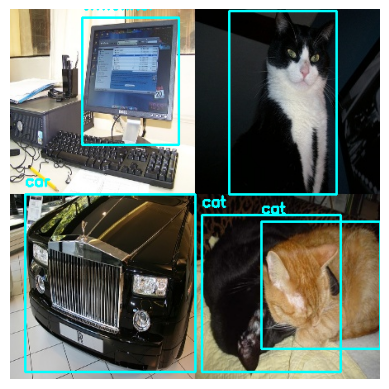

(448, 448, 3)
001411_mos.jpg


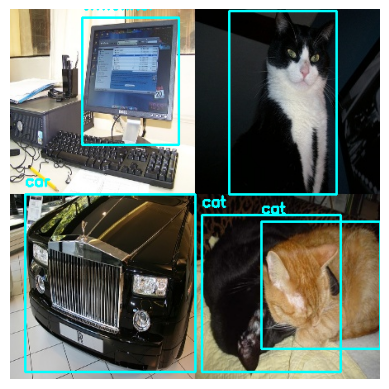

In [22]:
annotations = read_annotations(MOS_DATA_PATH)
show_visualization_multiple_boxes('./data/mos_JPEG/001411_mos.jpg', annotations['001411_mos.jpg'], classes_name)
show_visualization_multiple_boxes('./data/mos_JPEG/001411_mos.jpg', filter_bounding_boxes(annotations['001411_mos.jpg']), classes_name)

001132_mos.jpg
(448, 448, 3)
001132_mos.jpg


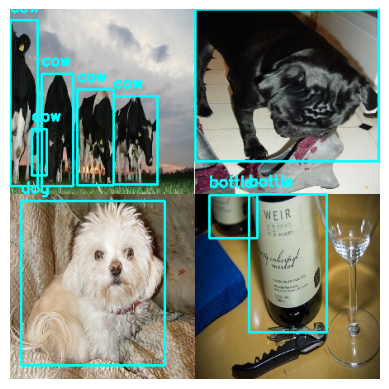

003182_mos.jpg
(448, 448, 3)
003182_mos.jpg


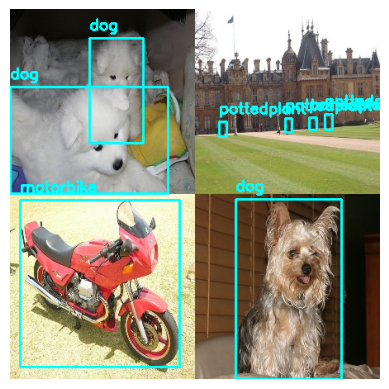

004949_mos.jpg
(448, 448, 3)
004949_mos.jpg


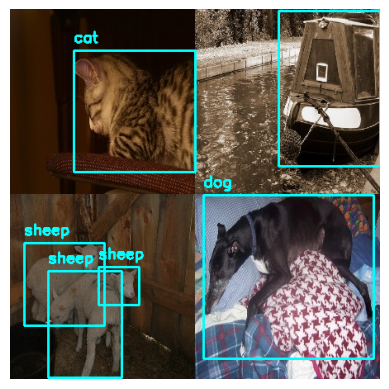

000038_mos.jpg
(448, 448, 3)
000038_mos.jpg


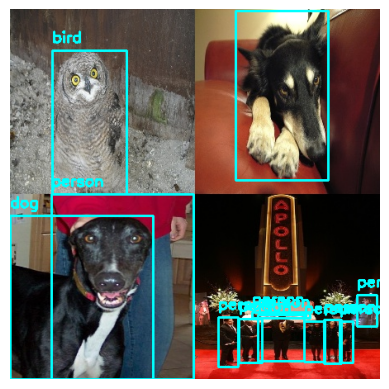

006226_mos.jpg
(448, 448, 3)
006226_mos.jpg


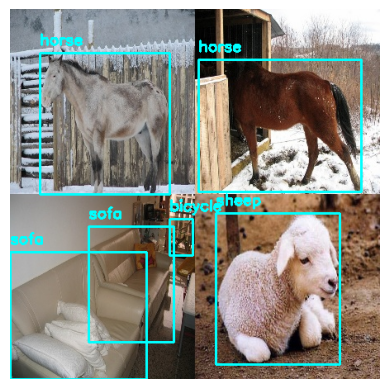

006833_mos.jpg
(448, 448, 3)
006833_mos.jpg


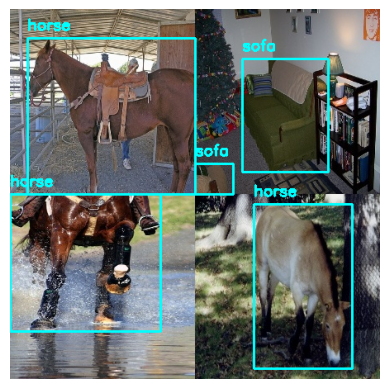

002654_mos.jpg
(448, 448, 3)
002654_mos.jpg


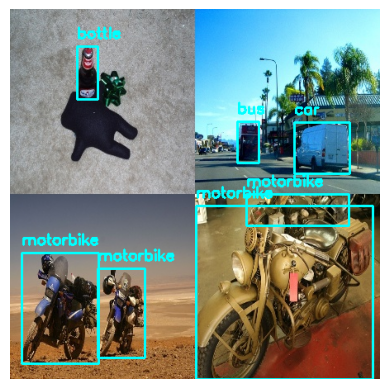

001677_mos.jpg
(448, 448, 3)
001677_mos.jpg


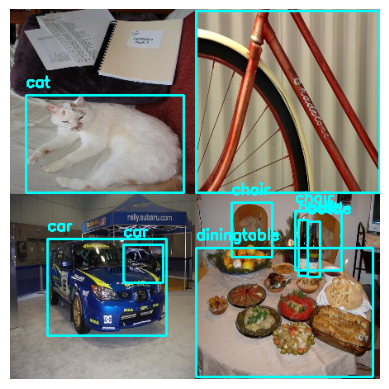

006526_mos.jpg
(448, 448, 3)
006526_mos.jpg


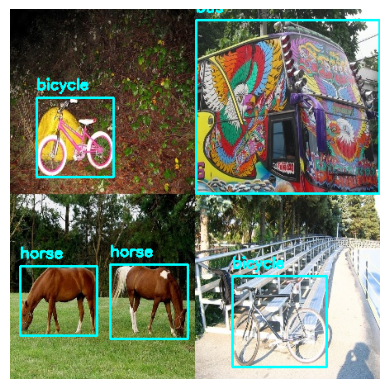

005306_mos.jpg
(448, 448, 3)
005306_mos.jpg


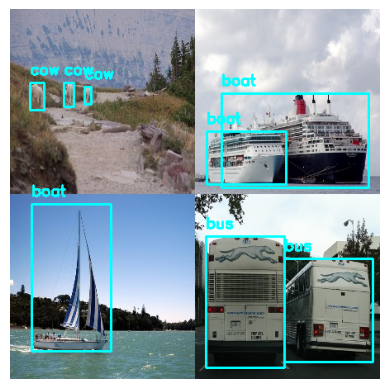

In [23]:
visualize_random_images(MOS_IMAGE_DIR, MOS_DATA_PATH, num_images = 10)

## Training

在模型設計部分，我們採用了 Transfer Learning的方法，將 YOLO 模型結構分為 Feature Extractor 與 YOLO-specific Design 兩個部分。

在 Feature Extractor 的選擇上，我們嘗試了多種由 Keras Applications 提供的pretrained model，包括 DenseNet 和 EfficientNet 等。在多次實驗中，我們發現 DenseNet201 表現最佳，因此最終選擇 DenseNet201 作為我們的Feature Extractor。

在 YOLO-specific Design部分，我們捨棄 YOLO 原始模型的過多參數設計，並結合 DenseNet 的高效特徵提取，降低了計算需求，

針對訓練資料的部分，我們結合了兩種資料增強策略：一般的augmentation（如翻轉、縮放、旋轉等）與 Mosaic 資料增強。我們設計了多階段的訓練流程，通過實驗發現以下策略最為有效：

在初期至中期的訓練階段，使用一般增強與 Mosaic 增強相結合的混合資料進行訓練，以快速提升模型的泛化能力。

在中後期的訓練階段，切換為僅使用非 Mosaic 增強的資料進行微調，以使Loss Curve更加平滑並有效收斂。

這樣的訓練策略顯著降低了最終的損失值，同時提升了模型的性能，並在評估階段取得了更高的Score。這一結果證明了增強方法與訓練階段設計的相輔相成，有助於提升 YOLO 模型的整體效能。

In [4]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 32
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './data/aug_training_data.txt'
IMAGE_DIR = './data/aug_JPEG/'
MOS_DATA_PATH = './data/mos_training_data.txt'
MOS_IMAGE_DIR = './data/mos_JPEG/'
COM_DATA_PATH = './data/combined_training_data.txt'
COM_IMAGE_DIR = './data/combined_JPEG/'
CKP_DIR = './ckpts/YOLO6'
# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 20
NOOBJECT_SCALE = 10
CLASS_SCALE = 15
COORD_SCALE = 70

# training params
LEARNING_RATE = 1e-5
EPOCHS = 10
MOS_EPOCHS = 0

In [5]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE , drop_remainder=True)
        dataset = dataset.prefetch(buffer_size = 200)

        return dataset

In [6]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)
    return x

def modified_yolo_with_densenet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    # Load DenseNet without top layers and set it as non-trainable
    densenet = DenseNet201(include_top = False, input_shape = input_shape)
    densenet.trainable = False  # Freeze DenseNet layers for feature extraction
    
    # Get DenseNet output as feature extractor
    x = densenet.output
    x = conv_leaky_relu(x, 512, 3, 1)
    x = conv_leaky_relu(x, 1024, 3, 1)
    
    # Pass DenseNet features to a reduced YOLO model
    x = conv_leaky_relu(x, 64, 3, 1)  # Use a smaller stride to preserve dimensions
    x = conv_leaky_relu(x, 128, 3, 1)
    x = layers.MaxPool2D()(x)

    x = conv_leaky_relu(x, 256, 3, 1)
    x = conv_leaky_relu(x, 512, 3, 1)
    x = conv_leaky_relu(x, 1024, 3, 1)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2048, kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01))(x)
    x = layers.LeakyReLU(0.1)(x)
    outputs = layers.Dense(1470, kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.01))(x)
    
    # Define the complete model
    model = models.Model(inputs=densenet.input, outputs=outputs, name="YOLO")
    return model



In [7]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [8]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [9]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [10]:
# Instantiate the model
YOLO = modified_yolo_with_densenet()
#YOLO = modified_yolo_with_efficientnet()
#YOLO.summary()

In [11]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [12]:
def combine_datasets(original_data_path, original_image_dir, additional_data_path, additional_image_dir,
                     combined_data_path, combined_image_dir):
    # 創建合併後的文件夾
    if not os.path.exists(combined_image_dir):
        os.makedirs(combined_image_dir)
    
    # 合併註釋文件
    with open(combined_data_path, 'w') as combined_file:
        with open(original_data_path, 'r') as original_file:
            combined_file.writelines(original_file.readlines())
        with open(additional_data_path, 'r') as additional_file:
            combined_file.writelines(additional_file.readlines())
    
    # 複製圖像文件到新的文件夾
    for image_file in os.listdir(original_image_dir):
        shutil.copy(os.path.join(original_image_dir, image_file), combined_image_dir)
    for image_file in os.listdir(additional_image_dir):
        shutil.copy(os.path.join(additional_image_dir, image_file), combined_image_dir)

    print("Datasets combined successfully.")

In [13]:
# ckpt.restore('./ckpts/YOLO/yolo-5')
ckpt = tf.train.Checkpoint(epoch = tf.Variable(0), net = YOLO)
manager = tf.train.CheckpointManager(ckpt, CKP_DIR, max_to_keep = 70, checkpoint_name='yolo')

In [ ]:
combine_datasets(
    original_data_path=DATA_PATH,
    original_image_dir=IMAGE_DIR,
    additional_data_path=MOS_DATA_PATH,
    additional_image_dir=MOS_IMAGE_DIR,
    combined_data_path=COM_DATA_PATH,
    combined_image_dir=COM_IMAGE_DIR)

DATA_PATH = COM_DATA_PATH
IMAGE_DIR = COM_IMAGE_DIR
dataset = DatasetGenerator().generate()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [15]:
ckpt = tf.train.Checkpoint(epoch = tf.Variable(0), net = YOLO)
ckpt.restore('./ckpts/YOLO5/yolo-40')

In [26]:
print(f'{datetime.now()}, start training.')


for i in range(EPOCHS):
    train_loss_metric.reset_state()
    ckpt.epoch.assign_add(1)

    if i == MOS_EPOCHS:
        DATA_PATH = './data/aug_training_data.txt'
        IMAGE_DIR = './data/aug_JPEG/'
        dataset = DatasetGenerator().generate()
        print("Stop MOS")
        
    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print(f'{datetime.now()}, Epoch {i+1}: loss {train_loss_metric.result():.2f}')

    save_path = manager.save()
    print(f'Saved checkpoint for epoch {int(ckpt.epoch)}: {save_path}')
    

2024-11-17 22:35:38.933432, start training.
Stop MOS


100%|██████████| 2420/2420 [07:17<00:00,  5.53it/s]


2024-11-17 22:42:56.605343, Epoch 1: loss 14.17
Saved checkpoint for epoch 41: ./ckpts/YOLO5/yolo-41


100%|██████████| 2420/2420 [07:17<00:00,  5.53it/s]


2024-11-17 22:50:14.570552, Epoch 2: loss 14.09
Saved checkpoint for epoch 42: ./ckpts/YOLO5/yolo-42


100%|██████████| 2420/2420 [07:16<00:00,  5.54it/s]


2024-11-17 22:57:31.900455, Epoch 3: loss 13.98
Saved checkpoint for epoch 43: ./ckpts/YOLO5/yolo-43


100%|██████████| 2420/2420 [07:18<00:00,  5.52it/s]


2024-11-17 23:04:50.234342, Epoch 4: loss 13.94
Saved checkpoint for epoch 44: ./ckpts/YOLO5/yolo-44


100%|██████████| 2420/2420 [07:17<00:00,  5.53it/s]


2024-11-17 23:12:07.890715, Epoch 5: loss 13.84
Saved checkpoint for epoch 45: ./ckpts/YOLO5/yolo-45


100%|██████████| 2420/2420 [07:17<00:00,  5.53it/s]


2024-11-17 23:19:25.540867, Epoch 6: loss 14.03
Saved checkpoint for epoch 46: ./ckpts/YOLO5/yolo-46


100%|██████████| 2420/2420 [07:17<00:00,  5.53it/s]


2024-11-17 23:26:43.294327, Epoch 7: loss 13.97
Saved checkpoint for epoch 47: ./ckpts/YOLO5/yolo-47


100%|██████████| 2420/2420 [07:17<00:00,  5.53it/s]


2024-11-17 23:34:00.846707, Epoch 8: loss 13.51
Saved checkpoint for epoch 48: ./ckpts/YOLO5/yolo-48


100%|██████████| 2420/2420 [07:17<00:00,  5.54it/s]


2024-11-17 23:41:18.193183, Epoch 9: loss 13.65
Saved checkpoint for epoch 49: ./ckpts/YOLO5/yolo-49


100%|██████████| 2420/2420 [07:17<00:00,  5.53it/s]


2024-11-17 23:48:36.326996, Epoch 10: loss 13.62
Saved checkpoint for epoch 50: ./ckpts/YOLO5/yolo-50


## Predict

在pridict的部分，我們改成可以輸出多個bounging box並使用non max suppression的方法，來避免同一個物件被預測出多個bounding box，用threshold來過濾掉confidence較低的bounding box，並且將重疊率較高的bounding box由confident score來代表。

In [16]:
ckpt = tf.train.Checkpoint(epoch = tf.Variable(0), net = YOLO)
ckpt.restore('./ckpts/YOLO5/yolo-50')

In [17]:
test_img_files = open('./data/pascal_voc_testing_data.txt')
test_img_dir = './data/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [18]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

In [19]:
def process_outputs(outputs , threshold = 0.5):
    '''
    Process YOLO outputs into bou
    '''
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, NUM_CLASSES))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL))
    boxes = np.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL * 4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, :NUM_CLASSES]
    C = predicts[0, :, :, NUM_CLASSES:NUM_CLASSES+BOXES_PER_CELL]
    coordinate = predicts[0, :, :, NUM_CLASSES+BOXES_PER_CELL:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, NUM_CLASSES))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    # P's shape [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, NUM_CLASSES]

    xmin, ymin, xmax, ymax, class_num, conf = [], [], [], [], [], []

    max_conf_idx = np.unravel_index(np.argmax(P), P.shape)
    if(P[max_conf_idx] > 0.3) :
        threshold = P[max_conf_idx] / 2

    result = []
    for i in range(np.prod(P.shape)):
        idx = np.unravel_index(i, P.shape)
        if (P[idx] > threshold):
            class_num = (idx[3])
            conf = (P[idx])
            coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))
            xcenter, ycenter, w, h = coordinate[idx[0], idx[1], idx[2], :]

            xcenter = (idx[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
            ycenter = (idx[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))

            w = w * IMAGE_SIZE
            h = h * IMAGE_SIZE

            xmin = (xcenter - w / 2.0)
            ymin = (ycenter - h / 2.0)

            xmax = xmin + w
            ymax = ymin + h
            result.append((xmin, ymin, xmax, ymax, class_num, conf))
    return result

In [20]:
def box_iou_batch(boxes_a, boxes_b):
    def box_area(box):
        return (box[2] - box[0]) * (box[3] - box[1])

    area_a = box_area(boxes_a.T)
    area_b = box_area(boxes_b.T)

    top_left = np.maximum(boxes_a[:, None, :2], boxes_b[:, :2])
    bottom_right = np.minimum(boxes_a[:, None, 2:], boxes_b[:, 2:])

    area_inter = np.prod(
        np.clip(bottom_right - top_left, a_min=0, a_max=None), 2)
        
    return area_inter / (area_a[:, None] + area_b - area_inter)
def non_max_suppression(predictions, iou_threshold = 0.5):
    rows, columns = predictions.shape

    sort_index = np.flip(predictions[:, 5].argsort())
    predictions = predictions[sort_index]

    boxes = predictions[:, :4]
    categories = predictions[:, 4]
    ious = box_iou_batch(boxes, boxes)
    ious = ious - np.eye(rows)

    keep = np.ones(rows, dtype=bool)

    for index, (iou, category) in enumerate(zip(ious, categories)):
        if not keep[index]:
            continue

        condition = (iou > iou_threshold) & (categories == category)
        keep = keep & ~condition

    return keep[sort_index.argsort()]

In [21]:
import sys
import pandas as pd
sys.path.insert(0, './evaluate')
import evaluate


ckpt = tf.train.Checkpoint(epoch = tf.Variable(0), net = YOLO)
ckpt.restore('./ckpts/YOLO5/yolo-50')

output_file = open('./test_prediction.txt', 'w')  
for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        all_boxes = process_outputs(prediction_step(test_img[i:i+1]) , 0.01)
        all_boxes = np.array(all_boxes)
        if len(all_boxes) == 0:
            continue
        keep = non_max_suppression(all_boxes , 0.4)
        nms_boxes = all_boxes[keep]
        for xmin, ymin, xmax, ymax, class_num, conf in nms_boxes:
            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1] / IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
            #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()
evaluate.evaluate('./test_prediction.txt', './output_file.csv')
cap = pd.read_csv('./output_file.csv')['packedCAP']
print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))

2024-11-17 23:55:52.517331: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
W0000 00:00:1731858952.555919 4083881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731858952.565383 4083881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731858952.566134 4083881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731858952.567457 4083881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731858952.567637 4083881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731858952.583910 4083881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731858952.584124 4083881 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731858952.584379 4083881 gpu_

End Evalutation
score: 0.408014


## Tuning

由於loss並不能直接反應score高低，我們使用for loop配合不同threshold來找到能在競賽中得到最佳結果的參數

In [22]:
import sys
import pandas as pd
sys.path.insert(0, './evaluate')
import evaluate

iou_thresholds = np.arange(0.4, 0.5, 0.1)
thresholds = np.arange(0.01, 0.012, 0.002)
name = './ckpts/YOLO4/yolo-'

min_score = 1
best_iou_thresholds = 0
best_thresholds = 0
best_ckpt =0

for k in range(41, 51):
    new_path = name + str(k)
    ckpt.restore(new_path)
    print("ckpt is " + str(k))
    for threshold in thresholds:
        for iou_threshold in iou_thresholds:
            output_file = open('./test_prediction.txt', 'w')
            print(f"threshold = {threshold} , iou_thresholds = {iou_threshold}")
            for img_name, test_img, img_h, img_w in test_dataset:
                        batch_num = img_name.shape[0]
                        for i in range(batch_num):
                            # xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
                            all_boxes = process_outputs(prediction_step(test_img[i:i+1]) , threshold)
                            all_boxes = np.array(all_boxes)
                            if len(all_boxes) == 0:
                                continue
                            keep = non_max_suppression(all_boxes , iou_threshold)
                            nms_boxes = all_boxes[keep]
                            for xmin, ymin, xmax, ymax, class_num, conf in nms_boxes:
                                xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1] / IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
                                #img filename, xmin, ymin, xmax, ymax, class, confidence
                                output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

            output_file.close()
            evaluate.evaluate('./test_prediction.txt', './output_file.csv')
            cap = pd.read_csv('./output_file.csv')['packedCAP']
            print('score: {:f}'.format(sum((1. - cap) ** 2) / len(cap)))
            if ((sum((1. - cap) ** 2) / len(cap)) < min_score):
                min_score = (sum((1. - cap) ** 2) / len(cap))
                best_iou_thresholds = iou_threshold
                best_thresholds = threshold
                best_ckpt = k


            # threshold 0.01 , iou_thresholds = 0.4

print(min_score,best_iou_thresholds,best_thresholds,best_ckpt)

ckpt is 41
threshold = 0.01 , iou_thresholds = 0.4


2024-11-18 00:01:29.182135: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


End Evalutation
score: 0.399309
ckpt is 42
threshold = 0.01 , iou_thresholds = 0.4
End Evalutation
score: 0.380482
ckpt is 43
threshold = 0.01 , iou_thresholds = 0.4


2024-11-18 00:05:01.369192: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


End Evalutation
score: 0.397581
ckpt is 44
threshold = 0.01 , iou_thresholds = 0.4
End Evalutation
score: 0.391721
ckpt is 45
threshold = 0.01 , iou_thresholds = 0.4
End Evalutation
score: 0.402038
ckpt is 46
threshold = 0.01 , iou_thresholds = 0.4
End Evalutation
score: 0.373006
ckpt is 47
threshold = 0.01 , iou_thresholds = 0.4


2024-11-18 00:12:10.030564: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


End Evalutation
score: 0.390879
ckpt is 48
threshold = 0.01 , iou_thresholds = 0.4
End Evalutation
score: 0.402184
ckpt is 49
threshold = 0.01 , iou_thresholds = 0.4
End Evalutation
score: 0.412804
ckpt is 50
threshold = 0.01 , iou_thresholds = 0.4
End Evalutation
score: 0.399112
0.3730055690700096 0.4 0.01 46


In [ ]:
ckpt = tf.train.Checkpoint(epoch = tf.Variable(0), net = YOLO)
ckpt.restore('./ckpts/YOLO2/yolo-38')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
np_img = cv2.imread('./data/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

all_boxes = process_outputs(prediction_step(np_img) , 0.01)
all_boxes = np.array(all_boxes)
keep = non_max_suppression(all_boxes , 0.4)
nms_boxes = all_boxes[keep]
for xmin, ymin, xmax, ymax, class_num, conf in nms_boxes:
    class_name = classes_name[int(class_num)]
    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()

## Conclusion